# 9-Qubit Error Correcting Code


#### In this notebook, we will show the functionality of the First Full Quantum Code.
#### We will refer back to the 3-Qubit Code, as the 9-Qubit Code is a repetition code.

In [163]:
import numpy as np

# Importing required libraries
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace

import random
from qiskit.extensions import UnitaryGate



# Visualization of circuits: Initializing backend simulators
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')



env: QISKIT_SETTINGS={}


## 3 Qubit Code Review

#### The 3 Qubit Code was shown to only be able to correct $\sigma_x$ (Bit-Flip) Errors
#### Only able to correct for one type of error at a time


### For $\sigma_z$ (Phase-Flip) Errors, does the error detection circuit signal an error?
#### We can build a circuit that detects phase-flip instead of bit-flip errors,
#### by instead encoding the qubits in a GHZ state in the $|±\rangle$ basis:
$\alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|+ + +\rangle + 
\beta|− − −\rangle $



### Gate Operations Review ( CX and CZ ):



#### The CNOT gate is typically used to establish entanglement between qubits and implement controlled operations. 


#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


#### The CZ gate, also known as the HGZ gate, is a two-qubit gate that introduces a phase shift of $\pi$ to the qubit state. 
#### Phase Shift: Refers to a change in the timing or alignment of a wave or oscillation. 


#### The Z gate is represented by the following matrix: $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}$$



####  When applied to the $\vert0\rangle$ state, 
$$Z\vert0\rangle = \vert0\rangle$$

#### However, when applied to the $\vert1\rangle$ state, the Z gate introduces a phase shift of $\pi$ (or a phase flip) to the state.  
$$Z\vert1\rangle = -\vert1\rangle$$





### Foundations of Correction

#### This algorithm a single logical qubit,  encoded using 9 physical qubits.
#### Able to correct for both a single $\sigma_x$ error per block of 3 Qubits (bit flip) 
#### and for a $\sigma_z$ (phase-flip). 

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $|0\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right)$ and
$|1\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right)$ and $\vert1\rangle_L = \vert111\rangle$

#### A single qubit state is still represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$




#### Below we show the quantum circuit for encoding a single logical qubit in a 9-qubit system.

## Implementing for $\sigma_x$ correction: Logical state of a 9 Qubit Code

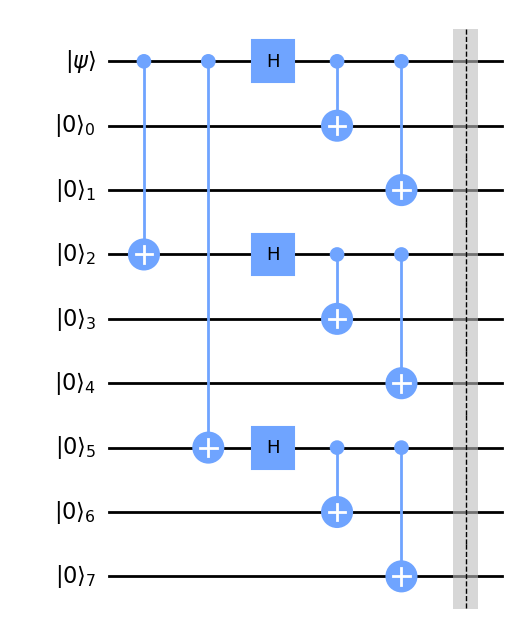

In [164]:

psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')

qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 3)
qc.cnot(0, 6)
qc.h(0)
qc.h(3)
qc.h(6)
qc.cnot(0, 1)
qc.cnot(3, 4)
qc.cnot(6, 7)
qc.cnot(0, 2)
qc.cnot(3, 5)
qc.cnot(6, 8)
qc.barrier()

qc.draw()
 

    
 

In [165]:

def nine_qubit_initialize_logical_state(initial_psi):
    initial_ancilla_state = np.array([1, 0])
    psi = initial_psi

    # Initializing the logical state with 8 ancillas
    initial_logical_state = np.kron(psi, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
        initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
            initial_ancilla_state,np.kron(initial_ancilla_state, initial_ancilla_state))))))))


    np.shape(initial_logical_state)

    # First two non-adjacent qubits on the left
    current_state = np.dot(CNOT(0, 3, 9), initial_logical_state)
    current_state = np.dot(CNOT(0, 6, 9), current_state)

    # All three Hadamard gates
    hadamards = np.kron(hadamard, np.kron(np.identity(2**2), np.kron(hadamard, np.kron(
        np.identity(2**2), np.kron(hadamard, np.identity(2**2))))))

    current_state = np.dot(hadamards, current_state)

    # The three adjacent qubits                                                                       
    current_state = np.dot(CNOT(0, 1, 9), current_state)
    current_state = np.dot(CNOT(3, 4, 9), current_state)
    current_state = np.dot(CNOT(6, 7, 9) , current_state)

    # Last three qubits
    current_state = np.dot(CNOT(0, 2, 9) , current_state)
    current_state = np.dot(CNOT(3, 5, 9) , current_state)
    current_state = np.dot(CNOT(6, 8, 9) , current_state)

    final_logical_state = np.kron(current_state, np.kron(np.array([1, 0]), np.array([1,0])))

    k = 9
    bit_representation = vector_state_to_bit_state(final_logical_state, k)[0]
    
    return final_logical_state

# Example usage
initial_psi = np.array([0, 1])
state = nine_qubit_initialize_logical_state(initial_psi)
print_state_info(state, 9)

000000000 :  0.3535533905932737
000000111 :  -0.3535533905932737
000111000 :  -0.3535533905932737
000111111 :  0.3535533905932737
111000000 :  -0.3535533905932737
111000111 :  0.3535533905932737
111111000 :  0.3535533905932737
111111111 :  -0.3535533905932737


## Initializing for our Phase Correction

### 9 Qubit Phase Flip Error Detection & Correction




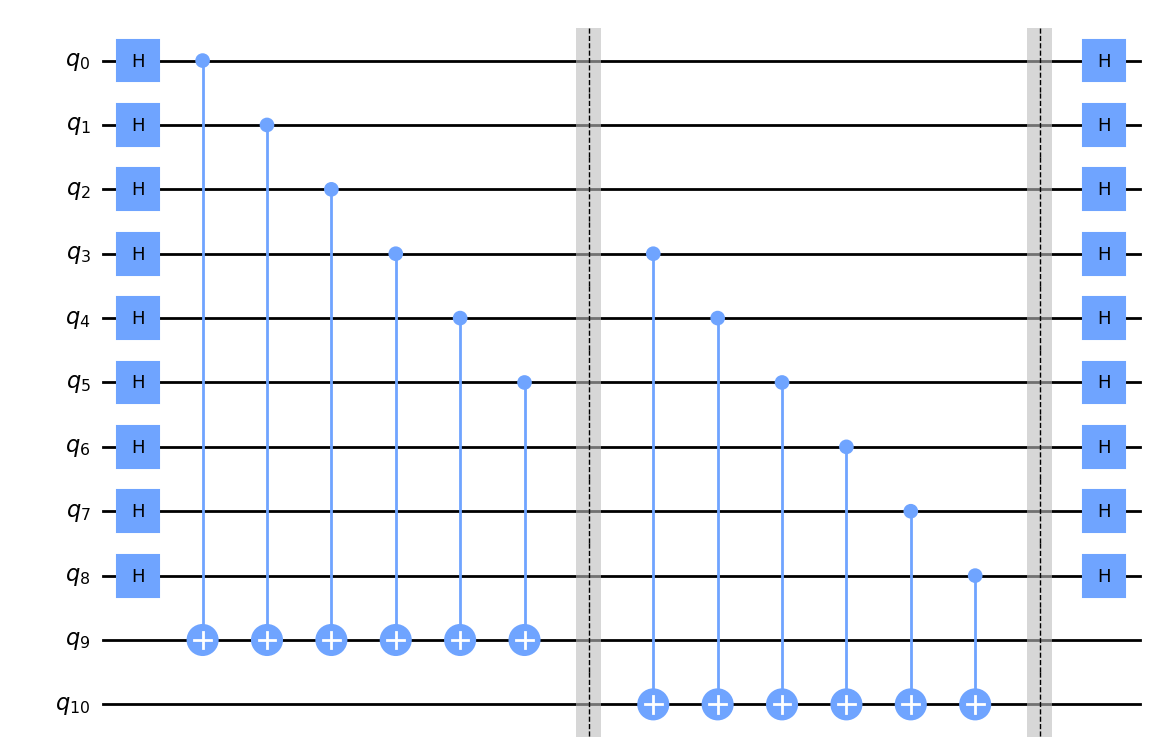

In [166]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')
additional_ancilla = QuantumRegister(10, '|0⟩')
qc = QuantumCircuit(11)

# Hadamard gates on the left side (vertical arrangement)
for i in range(9):
    qc.h(i)

# Define the Z error correction circuit for Shor's code
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(2, 9)
qc.cx(3, 9)
qc.cx(4, 9)
qc.cx(5, 9)
qc.barrier()
qc.cx(3, 10)
qc.cx(4, 10)
qc.cx(5, 10)
qc.cx(6, 10)
qc.cx(7, 10)
qc.cx(8, 10)

# Add barrier gate after the error correction circuit
qc.barrier()

# Hadamard gates on the right side (vertical arrangement)
for i in range(9):
    qc.h(i)
qc.draw()



In [167]:
# adding in ancilla qubits
zero = np.array([1, 0])
vector_state = np.kron(state, np.kron(zero, zero))
print_state_info(vector_state, 11)

00000000000 :  0.3535533905932737
00000011100 :  -0.3535533905932737
00011100000 :  -0.3535533905932737
00011111100 :  0.3535533905932737
11100000000 :  -0.3535533905932737
11100011100 :  0.3535533905932737
11111100000 :  0.3535533905932737
11111111100 :  -0.3535533905932737


In [168]:
def nine_qubit_corrected_phase_flip(logical_state):
    # logical_state: the full vector state representation of your 11 qubit system (9 data, 2 ancilla)
                                                 
     # First Nine Hadamard gates
    hadamards = np.kron(hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.identity(2**2))))))))))

    current_state = np.dot(hadamards, logical_state)                                            
                                                 
                                                 
    # First Set of 6 CNOTS (We use two sets to detect sign differences)
    current_state = np.dot(CNOT(0, 9, 11), current_state)
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(2, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 9, 11), current_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(5, 9, 11), current_state)
                        
                        
    # Second Set of 6 CNOTS 
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(4, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(7, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)
    
                        
    # Hadamards applied to each qubit on the right
    final_state = np.dot(hadamards, current_state) 
    final_state[np.abs(final_state) < 1e-15] = 0
    
    
    # Measure ancilla qubits
    final_state = collapse_ancilla(final_state, 2)
    
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Phase Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '0'):
        print('Phase Error in block 1')
        operation = np.kron(sigma_z, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Phase Error in block 3')
        operation = np.kron(np.identity(2**6),np.kron(sigma_z, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '1'):
        print('Phase Error in block 2')
        operation = np.kron(np.identity(2**3), np.kron(sigma_z, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state

# Example usage
final_state = nine_qubit_corrected_phase_flip(state)

print_state_info(final_state, 11)


No Phase Error Occured
00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


In [169]:
errored_state = random_qubit_z_error(state, qubit_range = [0,8])[0]
print_state_info(errored_state, 11)

00000000000 :  0.3535533905932737
00000011100 :  -0.3535533905932737
00011100000 :  -0.3535533905932737
00011111100 :  0.3535533905932737
11100000000 :  0.3535533905932737
11100011100 :  -0.3535533905932737
11111100000 :  -0.3535533905932737
11111111100 :  0.3535533905932737


In [170]:
corrected_state = nine_qubit_corrected_phase_flip(errored_state)
print_state_info(corrected_state, 11)

Phase Error in block 1
00000000010 :  (0.3535533905932731+0j)
00000011110 :  (-0.3535533905932731+0j)
00011100010 :  (-0.3535533905932731+0j)
00011111110 :  (0.3535533905932731+0j)
11100000010 :  (-0.3535533905932731+0j)
11100011110 :  (0.3535533905932731+0j)
11111100010 :  (0.3535533905932731+0j)
11111111110 :  (-0.3535533905932731+0j)


In [171]:
reset_state = ancilla_reset(corrected_state, 2)
print_state_info(reset_state, 11)

00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


## Bit-Flip Error Detection and Correction

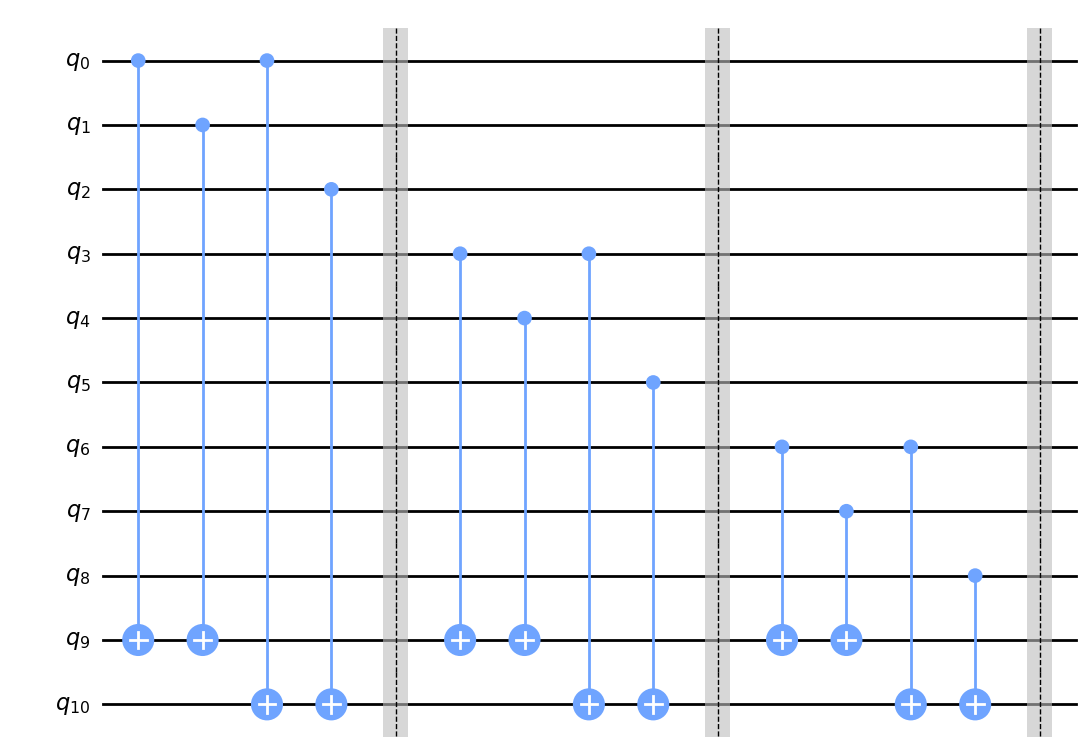

In [198]:
# Define the X error correction circuit for Shor's code

psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')
additional_ancilla = QuantumRegister(10, '|0⟩')
qc = QuantumCircuit(11)


# The first block of three qubits 
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(0, 10)
qc.cx(2, 10)
qc.barrier()

# The second block of three qubits
qc.cx(3, 9)
qc.cx(4, 9)
qc.cx(3, 10)
qc.cx(5, 10)
qc.barrier()

# The third block of three qubits

qc.cx(6, 9)
qc.cx(7, 9)
qc.cx(6, 10)
qc.cx(8, 10)
qc.barrier()


qc.draw()

##  Initialization: Bit-Flip Error Detection

In [199]:
    
# First block  

def first_block(logical_state):
    
    # We will treat this initialization in three blocks 
    # Each of the three (imaginary) blocks of the 9 Qubit Code, 
    # correspond to same behavior of the three qubit system.

    current_state = np.dot(CNOT(0, 9, 11), logical_state)   
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(0, 10, 11), current_state)
    current_state = np.dot(CNOT(2, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(sigma_x, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**9)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**8)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state


    
# Second Block
def second_block(logical_state): 
    # Second Block
    current_state = np.dot(CNOT(3, 9, 11), logical_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(np.identity(2**3),np.kron(sigma_x, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2**4),np.kron(sigma_x, np.identity(2**6)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**5),np.kron(sigma_x, np.identity(2**5)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state


# Third Block 
def third_block(logical_state):
    # Third Block
    current_state = np.dot(CNOT(6, 9, 11), logical_state)
    current_state = np.dot(CNOT(7, 9, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)
    
       
    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]
    
    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]
    
    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occured')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1')
        operation = np.kron(np.identity(2**6),np.kron(sigma_x, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2')
        operation = np.kron(np.identity(2**7),np.kron(sigma_x, np.identity(2**3)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3')
        operation = np.kron(np.identity(2**8),np.kron(sigma_x, np.identity(2**2)))
        corrected_state = np.dot(operation, final_state)
    
    return corrected_state   
    

In [202]:
print_state_info(reset_state, 11)

00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)


In [203]:
# This cell is specific to block 1 
errored_state = random_qubit_x_error(errored_state, [0,2])[0]   # The [0,2] show qubits 1,2, and 3
print_state_info(errored_state, 11)

01100000000 :  0.3535533905932737
01100011100 :  -0.3535533905932737
01111100000 :  -0.3535533905932737
01111111100 :  0.3535533905932737
10000000000 :  0.3535533905932737
10000011100 :  -0.3535533905932737
10011100000 :  -0.3535533905932737
10011111100 :  0.3535533905932737


In [204]:
# This cell is specific to block 2  
errored_state = random_qubit_x_error(errored_state, [3,5])[0]   # The [3,5] show qubits 4,5, and 6
print_state_info(errored_state, 11)


01101100000 :  -0.3535533905932737
01101111100 :  0.3535533905932737
01110000000 :  0.3535533905932737
01110011100 :  -0.3535533905932737
10001100000 :  -0.3535533905932737
10001111100 :  0.3535533905932737
10010000000 :  0.3535533905932737
10010011100 :  -0.3535533905932737


In [205]:
# This cell is specific to block 3
errored_state = random_qubit_x_error(errored_state, [6,8])[0]   # The [6,8] show qubits 7,8, and 9
print_state_info(errored_state, 11)


01101101000 :  -0.3535533905932737
01101110100 :  0.3535533905932737
01110001000 :  0.3535533905932737
01110010100 :  -0.3535533905932737
10001101000 :  -0.3535533905932737
10001110100 :  0.3535533905932737
10010001000 :  0.3535533905932737
10010010100 :  -0.3535533905932737


In [206]:
print_state_info(reset_state, 11)

print('This cell is specific to block 1 ')
errored_state = random_qubit_x_error(errored_state, [0,2])[0]   # The [0,2] show qubits 1,2, and 3
print_state_info(errored_state, 11)
print('This cell is specific to block 2 ')
errored_state = random_qubit_x_error(errored_state, [3,5])[0]   # The [3,5] show qubits 4,5, and 6
print_state_info(errored_state, 11)
print('This cell is specific to block 3 ')
errored_state = random_qubit_x_error(errored_state, [6,8])[0]   # The [6,8] show qubits 7,8, and 9
print_state_info(errored_state, 11)


00000000000 :  (0.3535533905932731+0j)
00000011100 :  (-0.3535533905932731+0j)
00011100000 :  (-0.3535533905932731+0j)
00011111100 :  (0.3535533905932731+0j)
11100000000 :  (-0.3535533905932731+0j)
11100011100 :  (0.3535533905932731+0j)
11111100000 :  (0.3535533905932731+0j)
11111111100 :  (-0.3535533905932731+0j)
This cell is specific to block 1 
00001101000 :  -0.3535533905932737
00001110100 :  0.3535533905932737
00010001000 :  0.3535533905932737
00010010100 :  -0.3535533905932737
11101101000 :  -0.3535533905932737
11101110100 :  0.3535533905932737
11110001000 :  0.3535533905932737
11110010100 :  -0.3535533905932737
This cell is specific to block 2 
00000001000 :  0.3535533905932737
00000010100 :  -0.3535533905932737
00011101000 :  -0.3535533905932737
00011110100 :  0.3535533905932737
11100001000 :  0.3535533905932737
11100010100 :  -0.3535533905932737
11111101000 :  -0.3535533905932737
11111110100 :  0.3535533905932737
This cell is specific to block 3 
00000000000 :  0.3535533905932

In [213]:
def nine_qubit_bit_flip_error_correction(logical_state):
    print_state_info(logical_state, 11)

    # First Block
    corrected_first_block_state = first_block(logical_state)
    print_state_info(corrected_first_block_state, 11)
    reset_state = ancilla_reset(corrected_first_block_state, 2)

    # Second Block
    corrected_second_block_state = second_block(reset_state)
    print_state_info(corrected_second_block_state, 11)
    reset_state = ancilla_reset(corrected_second_block_state, 2)

    # Third Block
    corrected_third_block_state = third_block(reset_state)
    print_state_info(corrected_third_block_state, 11)

    return corrected_first_block_state, corrected_second_block_state, corrected_third_block_state


### Performing error correction per block
#### 11 = Bit Error on Qubit 1
#### 10 = Bit Error on Qubit 2
#### 01 = Bit Error on Qubit 3

In [207]:
# This cell is specific to block 1 
corrected_first_block_state = first_block(errored_state)
print_state_info(corrected_first_block_state, 11)

No Bit Error Occured
00000000000 :  (0.3535533905932737+0j)
00000011100 :  (-0.3535533905932737+0j)
00011100000 :  (-0.3535533905932737+0j)
00011111100 :  (0.3535533905932737+0j)
11100000000 :  (0.3535533905932737+0j)
11100011100 :  (-0.3535533905932737+0j)
11111100000 :  (-0.3535533905932737+0j)
11111111100 :  (0.3535533905932737+0j)


In [214]:
# This cell is specific to block 2
# Now, we need to reset the ancillas
#collapse_ancilla(errored_state, 11)
errored_state =ancilla_reset(errored_state, 2) 
#reset_state = ancilla_reset(corrected_state, 2)

corrected_second_block_state = second_block(errored_state)
print_state_info(corrected_second_block_state, 11)

No Bit Error Occured
00000000000 :  (0.3535533905932737+0j)
00000011100 :  (-0.3535533905932737+0j)
00011100000 :  (-0.3535533905932737+0j)
00011111100 :  (0.3535533905932737+0j)
11100000000 :  (0.3535533905932737+0j)
11100011100 :  (-0.3535533905932737+0j)
11111100000 :  (-0.3535533905932737+0j)
11111111100 :  (0.3535533905932737+0j)


In [215]:
# This cell is specific to block 3

errored_state =ancilla_reset(errored_state, 2) 
#reset_state = ancilla_reset(corrected_state, 2)

corrected_third_block_state = third_block(errored_state)
print_state_info(corrected_third_block_state, 11)

No Bit Error Occured
00000000000 :  (0.3535533905932737+0j)
00000011100 :  (-0.3535533905932737+0j)
00011100000 :  (-0.3535533905932737+0j)
00011111100 :  (0.3535533905932737+0j)
11100000000 :  (0.3535533905932737+0j)
11100011100 :  (-0.3535533905932737+0j)
11111100000 :  (-0.3535533905932737+0j)
11111111100 :  (0.3535533905932737+0j)


## A Full 9 Qubit Degenerate Code

### Correcting for Simulataneous Phase and Bit-Flip Errors

In [219]:
def nine_qubit_error_correction(logical_state):
    # First Nine Hadamard gates
    hadamards = np.kron(hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
        hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
        hadamard, np.kron(hadamard, np.kron(hadamard, np.identity(2**2))))))))))

    current_state = np.dot(hadamards, logical_state)

    # First Block
    current_state = np.dot(CNOT(0, 9, 11), current_state)
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(0, 10, 11), current_state)
    current_state = np.dot(CNOT(2, 10, 11), current_state)

    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]

    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]

    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occurred in Block 1')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1 in Block 1')
        operation = np.kron(sigma_x, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2 in Block 1')
        operation = np.kron(np.identity(2), np.kron(sigma_x, np.identity(2**9)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3 in Block 1')
        operation = np.kron(np.identity(2**2), np.kron(sigma_x, np.identity(2**8)))
        corrected_state = np.dot(operation, final_state)

    # Reset ancilla
    corrected_state = reset_ancilla(corrected_state, 2)

    # Second Block
    current_state = np.dot(CNOT(3, 9, 11), corrected_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)

    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]

    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]

    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occurred in Block 2')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1 in Block 2')
        operation = np.kron(np.identity(2**3),np.kron(sigma_x, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2 in Block 2')
        operation = np.kron(np.identity(2**4),np.kron(sigma_x, np.identity(2**6)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3 in Block 2')
        operation = np.kron(np.identity(2**5),np.kron(sigma_x, np.identity(2**5)))
        corrected_state = np.dot(operation, final_state)

    # Reset ancilla
    corrected_state = reset_ancilla(corrected_state, 2)

    # Third Block
    current_state = np.dot(CNOT(6, 9, 11), corrected_state)
    current_state = np.dot(CNOT(7, 9, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)

    # Measure ancilla qubits
    final_state = collapse_ancilla(current_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]

    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]

    if (a1 == '0') and (a2 == '0'):
        print('No Bit Error Occurred in Block 3')
        corrected_state = final_state
    elif (a1 == '1') and (a2 == '1'):
        print('Bit Error in qubit 1 in Block 3')
        operation = np.kron(np.identity(2**6),np.kron(sigma_x, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '0'):
        print('Bit Error in qubit 2 in Block 3')
        operation = np.kron(np.identity(2**7),np.kron(sigma_x, np.identity(2**3)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Bit Error in qubit 3 in Block 3')
        operation = np.kron(np.identity(2**8),np.kron(sigma_x, np.identity(2**2)))
        corrected_state = np.dot(operation, final_state)

    # Phase Flip Error Correction
    # Measure ancilla qubits
    final_state = collapse_ancilla(corrected_state, 2)
    ancilla_bits = vector_state_to_bit_state(final_state, 11)[0][0][9:]

    a1 = ancilla_bits[0]
    a2 = ancilla_bits[1]

    if (a1 == '0') and (a2 == '0'):
        print('No Phase Error Occurred')
    elif (a1 == '1') and (a2 == '0'):
        print('Phase Error in Block 1')
        operation = np.kron(sigma_z, np.identity(2**10))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '0') and (a2 == '1'):
        print('Phase Error in Block 3')
        operation = np.kron(np.identity(2**6),np.kron(sigma_z, np.identity(2**4)))
        corrected_state = np.dot(operation, final_state)
    elif (a1 == '1') and (a2 == '1'):
        print('Phase Error in Block 2')
        operation = np.kron(np.identity(2**3), np.kron(sigma_z, np.identity(2**7)))
        corrected_state = np.dot(operation, final_state)

    return corrected_state


## Degeneracy in Error Correction
#### Regardless of what qubit is affected, the procedure will correct without a one-to-one correspondence

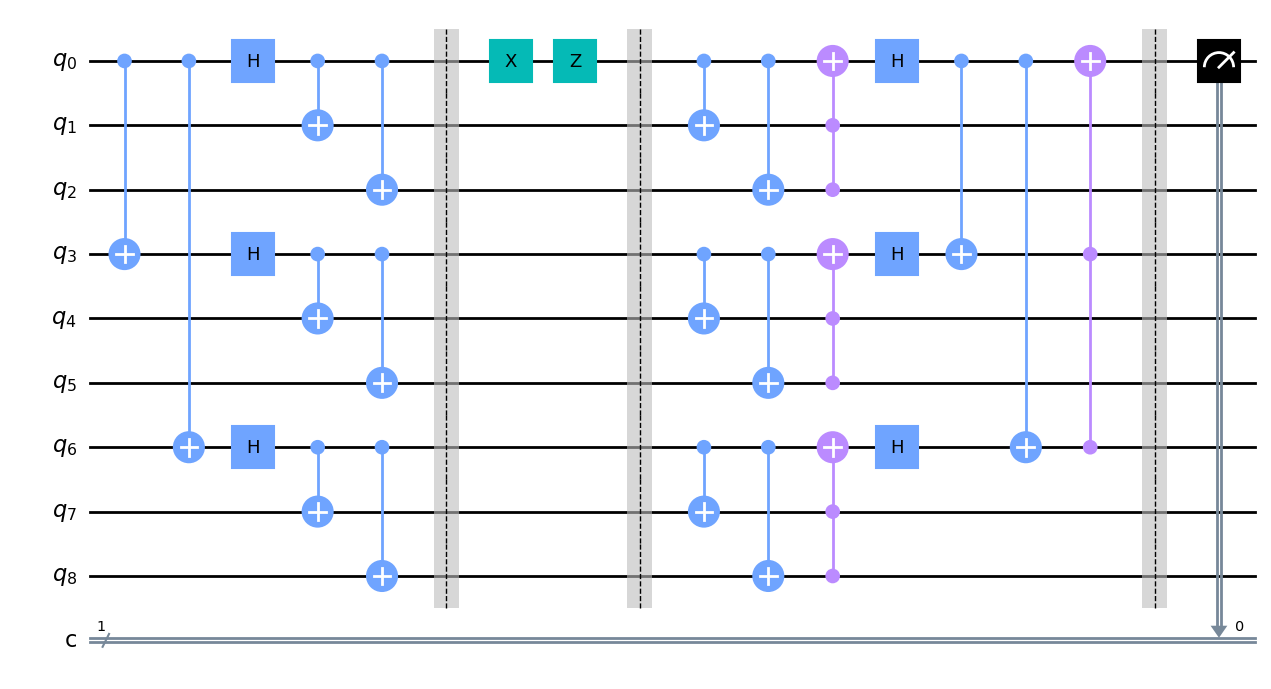

In [25]:
#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
#circuit.x(q[5])#Bit flip error
#circuit.x(q[8])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw()